In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk

In [2]:
df = pd.read_csv(r'C:\Users\DELL\OneDrive\Documents\ML\IMDB Dataset of 50K Movie Reviews\IMDB Dataset.csv')
print(df.shape)

(50000, 2)


In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [5]:
print(df.isnull().sum())
print(df.duplicated().sum())

review       0
sentiment    0
dtype: int64
418


In [6]:
print(df.duplicated().sum())

418


In [7]:
df_sentiment = df[['review']]

In [8]:
duplicated_rows = df_sentiment[df_sentiment.duplicated(keep=False)]

In [9]:
duplicated_rows.head(4)

,review
42,"Of all the films I have seen, this one, The Ra..."
84,"We brought this film as a joke for a friend, a..."
140,"Before I begin, let me get something off my ch..."
219,Ed Wood rides again. The fact that this movie ...


In [10]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [11]:
df['review'].duplicated(keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
49995    False
49996    False
49997    False
49998    False
49999    False
Name: review, Length: 50000, dtype: bool

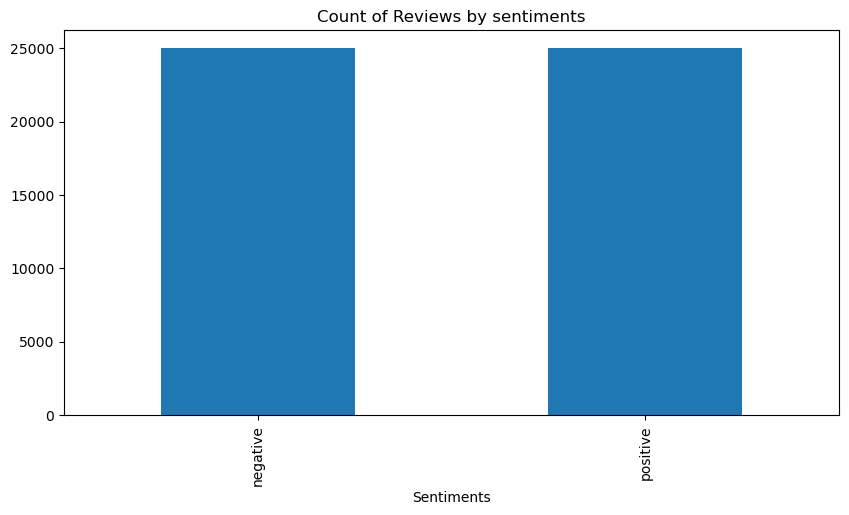

In [12]:
ax = df['sentiment'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by sentiments',
          figsize=(10, 5))
ax.set_xlabel('Sentiments')
plt.show()

In [13]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [14]:
###both sentiments are equally distributed

## Going with stacked lstm/Bidirectional lstm approach as we have labeled dataset
- Stacked LSTMs: Suitable for training on labeled sentiment data, especially when dealing with longer and more complex texts, allowing for learning contextual and sequential dependencies in the data.
- Bidirectional LSTM: Use when context from both past and future data points is essential
- VADER: Ideal for quick, rule-based sentiment analysis on short texts or when you have pre-labeled sentiment scores (like star ratings).As I had this specific dataset where I used Vader approach I am sure about this !

> I will try (Bidirectional)RNN, LSTM, GRU to check which one will give better accuracy!

### Steps
- cleaning our data -> removing whitespaces and special characters
- or converting it into lowercase to ensure uniformity (if further needed)!
- Tokenization
- Padding
- using label encoder for output/target (sentiment) which will be our Y
- next up splitting the dataset
- Building/training our required lstm model(gru,rnn)
- Saving the model

In [15]:
df['review'] = df['review'].str.lower()

In [16]:
df['review'] = df['review'].str.replace(r'[^\w\s]', '', regex=True)

In [17]:
df['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production br br the filmin...
2        i thought this was a wonderful way to spend ti...
3        basically theres a family where a little boy j...
4        petter matteis love in the time of money is a ...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i am a catholic taught in parochial elementary...
49998    im going to have to disagree with the previous...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

#### Tokenization

##### Starting with basic NLTK
- NLTK : Use for preprocessing tasks like tokenization before feeding data into the LSTM model.

In [18]:
ex = df['review'][20]
print(ex)

after the success of die hard and its sequels its no surprise really that in the 1990s a glut of die hard on a  movies cashed in on the wrong guy wrong place wrong time concept that is what they did with cliffhanger die hard on a mountain just in time to rescue sly stop or my mom will shoot stallones careerbr br cliffhanger is one big nitpickers dream especially to those who are expert at mountain climbing basejumping aviation facial expressions acting skills all in all its full of excuses to dismiss the film as one overblown pile of junk stallone even managed to get outacted by a horse however if you an forget all the nonsense its actually a very lovable and undeniably entertaining romp that delivers as plenty of thrills and unintentionally plenty of laughsbr br youve got to love john lithgows sneery evilness his tick every box band of baddies and best of all the permanently harassed and hapless turncoat agent rex linn as traversbr br he may of been henry in portrait of a serial kille

In [19]:
##tokenizaton
tokens = nltk.word_tokenize(ex)
tokens[:10]

['after',
 'the',
 'success',
 'of',
 'die',
 'hard',
 'and',
 'its',
 'sequels',
 'its']

In [37]:
from nltk.tokenize import word_tokenize
df['tokens'] = df['review'].apply(word_tokenize)

In [38]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
# Get the vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1 
print(f"Vocabulary Size: {vocabulary_size}")

Vocabulary Size: 181879


In [39]:
# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['review'])

In [40]:
# Analyze sequence lengths
lengths = [len(seq) for seq in sequences]

In [66]:
# Determine maxlen using percentiles
max_len_95 = int(np.percentile(lengths, 95))  # Covering 95% of the sequences
max_len_90 = int(np.percentile(lengths, 90))  # Covering 90% of the sequences

print(f"95th percentile max length: {max_len_95}")
print(f"90th percentile max length: {max_len_90}")

95th percentile max length: 587
90th percentile max length: 449


In [67]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = max_len_95
padded_sequences = pad_sequences(sequences, maxlen=max_len,padding='post')

In [68]:
padded_sequences

array([[  28,    4,    1, ...,    0,    0,    0],
       [   3,  384,  115, ...,    0,    0,    0],
       [   9,  195,   10, ...,    0,    0,    0],
       ...,
       [   9,  227,    3, ...,    0,    0,    0],
       [ 141,  161,    5, ...,    0,    0,    0],
       [  55,   28, 5812, ...,    0,    0,    0]])

In [69]:
X=padded_sequences
y=df['sentiment'].values

In [70]:
label_encoder = LabelEncoder()
encoded_labels_y = label_encoder.fit_transform(y)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels_y, test_size=0.2, random_state=42)

In [72]:
X_train.shape,X_test.shape

((40000, 587), (10000, 587))

### Bidirectional-LSTM

In [73]:
embedding_dim = 100  
vocab_size =vocabulary_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

In [78]:
embedding_dim = 100 
vocab_size = 181879 
max_len = 587 

In [84]:
# Now Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,  input_shape=(max_len,)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))  


In [87]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),batch_size=32)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
## with more layers

In [82]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_len,)),  # Use input_shape instead of input_length
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [85]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [86]:
model_lstm.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)           │ (None, 587, 100)              │  18,187,900 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bidirectional_2 (Bidirectional)    │ (None, 587, 128)              │      84,480 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bidirectional_3 (Bidirectional)    │ (None, 64)                    │      41,216 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_2 (Dense)                    │ (None, 32)                    │       2,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_3 (Dense)                    │ (None, 1)                     │          33 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 18,315,709 (69.87 MB)

 Trainable params: 18,315,709 (69.87 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    model_lstm.load_weights(latest_checkpoint)  # Load weights from the checkpoint
    print(f"Restored model from {latest_checkpoint}")
    
else:
    print("For Now there is no latest checkpoint")

In [129]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
checkpoint_dir = r'C:\Users\DELL\OneDrive\Desktop'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
# Callback for saving checkpoints
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_prefix,  
    save_weights_only=True,      
    save_freq='epoch',           
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',         
    patience=3         )         

In [131]:
history_lstm = model_lstm.fit(
    X_train, 
    y_train, 
    epochs=10, 
    validation_data=(X_test, y_test),
    batch_size=32, 
    callbacks=[checkpoint_callback, early_stopping_callback]  # Including the callbacks
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47458s 38s/step - accuracy: 0.9942 - loss: 0.0212 - val_accuracy: 0.8971 - val_loss: 0.3821
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1037s 830ms/step - accuracy: 0.9937 - loss: 0.0192 - val_accuracy: 0.8830 - val_loss: 0.5431
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 914s 731ms/step - accuracy: 0.9967 - loss: 0.0109 - val_accuracy: 0.8893 - val_loss: 0.5256
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 887s 709ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.8880 - val_loss: 0.5321


In [133]:
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 192ms/step - accuracy: 0.8896 - loss: 0.5119
Test Accuracy: 88.80%


In [143]:
tf.keras.backend.clear_session()

In [163]:
model_lstm.save(r'C:\Users\DELL\OneDrive\Desktop\my_model_bi_lstm.keras')

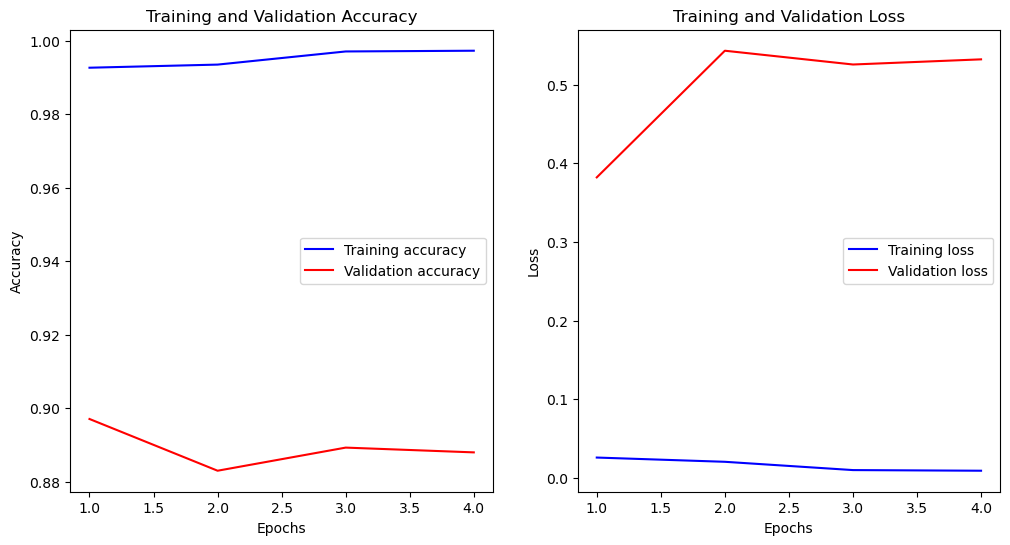

In [165]:
import matplotlib.pyplot as plt

# Assuming you have already trained the model and stored the history in the variable `history`
# history = model.fit(...)

# Retrieve training and validation metrics from the history object
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
# Determine the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()

### Bidirectional-RNN

In [97]:
embedding_dim = 100  
vocab_size =vocabulary_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file = r'C:\Users\DELL\OneDrive\Desktop\glove.6B.100d.txt'  
embeddings_index = load_glove_embeddings(glove_file)

In [98]:
embedding_dim = 100  # Match this with the GloVe file dimension
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [111]:
model_bi_rnn = Sequential()
model_bi_rnn.add(Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           embeddings_initializer=Constant(embedding_matrix),
                           input_shape=(max_len,),
                           trainable=False))
model_bi_rnn.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
model_bi_rnn.add(Bidirectional(SimpleRNN(32)))
model_bi_rnn.add(Dense(32, activation='relu'))
model_bi_rnn.add(Dense(1, activation='sigmoid'))


In [120]:

model_bi_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model_bi_rnn.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)           │ (None, 587, 100)              │  18,187,900 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bidirectional_15 (Bidirectional)   │ (None, 587, 128)              │      21,120 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bidirectional_16 (Bidirectional)   │ (None, 64)                    │      10,304 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_11 (Dense)                   │ (None, 32)                    │       2,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_12 (Dense)                   │ (None, 1)                     │          33 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 18,221,437 (69.51 MB)

 Trainable params: 18,221,437 (69.51 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
history_rnn = model_bi_rnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test),batch_size=32)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 956s 753ms/step - accuracy: 0.5704 - loss: 0.6763 - val_accuracy: 0.6731 - val_loss: 0.6034
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 975s 780ms/step - accuracy: 0.6597 - loss: 0.6148 - val_accuracy: 0.5944 - val_loss: 0.6542
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 893s 715ms/step - accuracy: 0.6987 - loss: 0.5725 - val_accuracy: 0.6512 - val_loss: 0.6302
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 741s 593ms/step - accuracy: 0.7501 - loss: 0.5188 - val_accuracy: 0.7005 - val_loss: 0.5872
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 777s 622ms/step - accuracy: 0.7646 - loss: 0.4870 - val_accuracy: 0.6964 - val_loss: 0.6100
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 783s 626ms/step - accuracy: 0.8084 - loss: 0.4201 - val_accuracy: 0.7297 - val_loss: 0.5750
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 821s 656ms/step - accuracy: 0.8193 - loss: 0.4068 - val_accuracy: 0.7021 - val_loss: 0.6208
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 848s 678ms/step - ac

In [150]:
model_bi_rnn.save(r'C:\Users\DELL\OneDrive\Desktop\my_new_model_bi_rnn.keras')
tf.saved_model.save(model_bi_rnn, r'C:\Users\DELL\OneDrive\Desktop\my_new_model_bi_rnn')

INFO:tensorflow:Assets written to: C:\Users\DELL\OneDrive\Desktop\my_new_model_bi_rnn\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\OneDrive\Desktop\my_new_model_bi_rnn\assets


In [123]:
model_bi_rnn.evaluate(X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - accuracy: 0.7339 - loss: 0.6360


[0.6401376724243164, 0.7327276468276978]

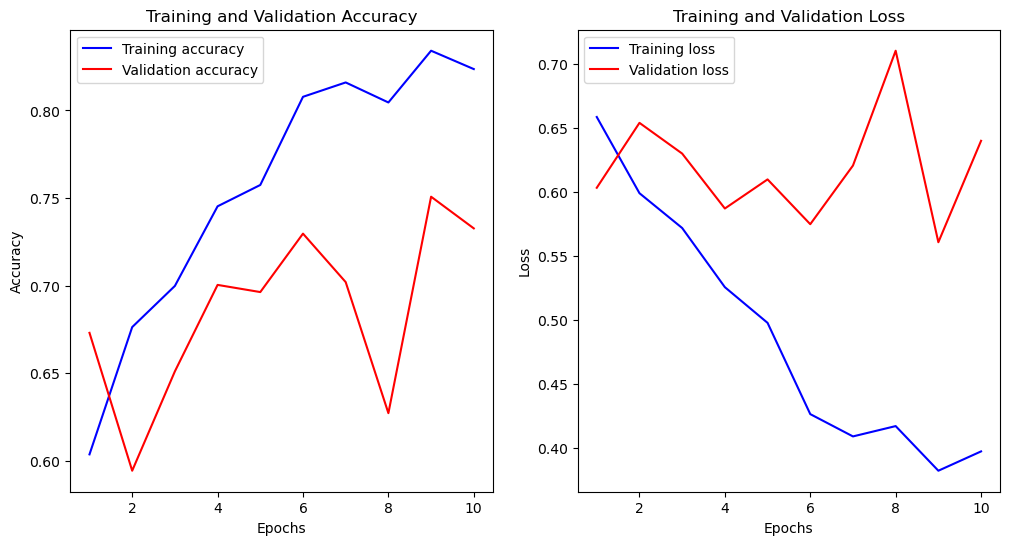

In [160]:
import matplotlib.pyplot as plt

# Assuming you have already trained the model and stored the history in the variable `history`
# history = model.fit(...)

# Retrieve training and validation metrics from the history object
acc = history_rnn.history['accuracy']
val_acc = history_rnn.history['val_accuracy']
loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']
# Determine the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()